# Analiza podatkov
V sledečem zvezku se nahaja analiza podatkov iz spletne strani [Musescore](https://musescore.com/sheetmusic).

V _prvem delu_ bom izvedla preprosto analizo pridobljenih podatkov. 
Zanimalo me bo, kako se posamezni parametri povezujejo s popularnostjo skladbe ter povezave med parametri.
Konkretno želim odgovoriti na naslednja vprašanja:
* Katerih skladb je največ nasploh in za specifične kategorije?
* Katere so najpopularnejše?
* Kakšna je povezava med popularnostjo in številčnostjo nasploh in glede na kategorije?
* Kakšne so lasnosti skladb, ki spadajo v Klasično glasbo?


V _drugem delu_ se bom lotila nekoliko zahtevnejše analize.
Zanimalo me bo, če obstaja recept za uspešno objavo - pri tem bom uporabila pridobljene informacije iz prvega dela; hkrati pa bom izdelala napovedovalec popularnosti skladbe glede na parametre, kot je žanr, inštrument in podobno.

Zanimala pa me bo tudi časovna slika podatkov. Tako bom podatke razdelila na smiselne časovne intervale in znotraj teh poiskala parametre, kot je povprečna zvrst, dolžina itn. objavljenih skladb v tem obdobju; prav tako pa bom po zastopanosti v tem obdobju uredila originale. Iskala bom obdobja večjih sprememb v podatkih in poskusila najti odgovor, zakaj je do njih prišlo. Zanimala me bo dominantnost posameznih žanrov in inštrumentov, z analizo žanrov pa bom tudi ustvarila sliko glasbenih okusov skozi čas.  
Glede na rezultate bom ustvarila tudi predpostavke za spremembe trendov v prihodnosti.  
Dobljene rezultate bom tudi vizualno predstavila s smiselnimi grafi.
Ugotovitve o časovnih trendih bom dodala svojemu napovedovalcu popularnosti.

## Uvoz podatkov

In [1]:
# Naložimo potrebne knjižnjice
import pandas as pd
import os.path 
import ast
import seaborn

# prikaz grafov
%matplotlib inline

#Nastavimo izpisovanje po 4 vrstice, saj delamo z ogromno količino podatkov, in bi bile razpredelnice sicer prevelike.
pd.options.display.max_rows = 4

In [2]:
# naložimo osnovno razpredelnico, s katero bomo delali
music = pd.read_csv(os.path.join('obdelani-podatki','all_music.csv'), index_col="music_id")

In [3]:
music

,title,rating,votes,ensemble,instrument,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link
music_id,,,,,,,,,,,,,,,
4197961,Merry-Go-Round of Life: Howl's Moving Castle P...,4.77,47676,Solo Piano,['Piano'],"['B♭ major', 'G minor']","Jul 05, 2017",05:15,NE,181934,Intermediate,7,4589622,1,https://musescore.com/user/16006641/scores/419...
3291706,River Flows In You,4.68,45503,Solo Piano,['Piano'],"['A major', 'F♯ minor']","Jan 24, 2017",02:47,NE,207886,Intermediate,4,5975850,1,https://musescore.com/user/12461571/scores/329...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926407,Cruel Angel's Thesis - Piano Cover by Theishter,4.86,323,Solo Piano,['Piano'],"['E♭ major', 'C minor']","Feb 07, 2018",01:33,NE,1732,Advanced,3,49784,1,https://musescore.com/user/27635868/scores/492...
5087038,Vincent Starry Starry Night,4.67,323,Solo Piano,['Piano'],"['G major', 'E minor']","May 08, 2018",04:08,NE,1200,Intermediate,4,53453,1,https://musescore.com/user/28424340/scores/508...


Tabelo želimo nekoliko popraviti. Tonalitete bi radi v obliki enega samega niza; pri tem upoštevamo, da je vedno podan par komplementnih tonalitet.

In [4]:
# Podatki v tabeli le izgledajo kot seznami, vendar so v resnici tipa string. To popravimo z uporabo knjižnjice ast
music["key"] = music["key"].apply(ast.literal_eval)

# Funkcija, ki združuje dva elementa seznama
def concatenate_key(key_list):
    return ', '.join(key_list)

# To funkcijo uporabimo na naši tabeli
music['key'] = music['key'].apply(concatenate_key)

music

,title,rating,votes,ensemble,instrument,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link
music_id,,,,,,,,,,,,,,,
4197961,Merry-Go-Round of Life: Howl's Moving Castle P...,4.77,47676,Solo Piano,['Piano'],"B♭ major, G minor","Jul 05, 2017",05:15,NE,181934,Intermediate,7,4589622,1,https://musescore.com/user/16006641/scores/419...
3291706,River Flows In You,4.68,45503,Solo Piano,['Piano'],"A major, F♯ minor","Jan 24, 2017",02:47,NE,207886,Intermediate,4,5975850,1,https://musescore.com/user/12461571/scores/329...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926407,Cruel Angel's Thesis - Piano Cover by Theishter,4.86,323,Solo Piano,['Piano'],"E♭ major, C minor","Feb 07, 2018",01:33,NE,1732,Advanced,3,49784,1,https://musescore.com/user/27635868/scores/492...
5087038,Vincent Starry Starry Night,4.67,323,Solo Piano,['Piano'],"G major, E minor","May 08, 2018",04:08,NE,1200,Intermediate,4,53453,1,https://musescore.com/user/28424340/scores/508...


Popraviti želimo tudi stolpec "duration". Podatki v njem so tipa string, nam pa bo primernejši za uporabo tip int, s katerim bomo lažje pretvarjali dane podatke v timedelta format.

In [5]:
# Pretvorba v sekunde, ki ulovi primere, ko nimamo podatkov
def convert_to_seconds(duration):
    if pd.isna(duration) or not isinstance(duration, str):
        return None
    parts = duration.split(':')
    if len(parts) == 2:
        try:
            minutes, seconds = map(int, parts)
            return minutes * 60 + seconds
        except ValueError:
            return None
    return None

music['duration_seconds'] = music['duration'].apply(convert_to_seconds)
music

,title,rating,votes,ensemble,instrument,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link,duration_seconds
music_id,,,,,,,,,,,,,,,,
4197961,Merry-Go-Round of Life: Howl's Moving Castle P...,4.77,47676,Solo Piano,['Piano'],"B♭ major, G minor","Jul 05, 2017",05:15,NE,181934,Intermediate,7,4589622,1,https://musescore.com/user/16006641/scores/419...,315.0
3291706,River Flows In You,4.68,45503,Solo Piano,['Piano'],"A major, F♯ minor","Jan 24, 2017",02:47,NE,207886,Intermediate,4,5975850,1,https://musescore.com/user/12461571/scores/329...,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926407,Cruel Angel's Thesis - Piano Cover by Theishter,4.86,323,Solo Piano,['Piano'],"E♭ major, C minor","Feb 07, 2018",01:33,NE,1732,Advanced,3,49784,1,https://musescore.com/user/27635868/scores/492...,93.0
5087038,Vincent Starry Starry Night,4.67,323,Solo Piano,['Piano'],"G major, E minor","May 08, 2018",04:08,NE,1200,Intermediate,4,53453,1,https://musescore.com/user/28424340/scores/508...,248.0


In [6]:
music.rename(columns={"instrument":"all_instruments"}, inplace=True)

Naložimo tudi pomožne razpredelnice, v katerih imamo dodatne podatke o avtorjih, uporabnikih, itd.

In [7]:
authors = pd.read_csv(os.path.join('obdelani-podatki','authors.csv'), index_col="author_id")
genres = pd.read_csv(os.path.join('obdelani-podatki','genres.csv'))
users = pd.read_csv(os.path.join('obdelani-podatki','users.csv'), index_col="user_id")
relacije_authors = pd.read_csv(os.path.join('obdelani-podatki','relacije_authors.csv'))
relacije_users = pd.read_csv(os.path.join('obdelani-podatki','relacije_users.csv'))

Pomagale nam bodo še naslednje tabele.

* tabela z urejenimi originali in informacijo o številu ponovitev

In [8]:
# Tabela s surovimi podatki
originals = relacije_authors.copy()

# Razvrstimo po skupinah glede na originalne avtorje in originalne naslove ter jih obdelamo
originals = originals.groupby(['original_author', 'original_title'])['music_id'].agg(list).reset_index()

# Dolžina seznama pri vsakem originalu nam pove, koliko vnosov mu pripada
originals['repetitions'] = originals['music_id'].apply(len)
originals


,original_author,original_title,music_id,repetitions
0,0,H0me Sw33t H0me,[5467064],1
1,7,Orange,[2497626],1
...,...,...,...,...
1183,447430,Cupid,[10367578],1
1184,452182,CMP,[6305471],1


* tabela s podatki o inštrumentih, ki niso več v obliki seznamov

In [9]:
# Podatki v tabeli le izgledajo kot seznami, vendar so v resnici tipa string. To popravimo z uporabo knjižnjice ast
music["all_instruments"] = music["all_instruments"].apply(ast.literal_eval)

# Izberemo le podatke o inštrumentih
instruments_lists = music[["all_instruments"]].copy().reset_index()

# Metoda explode pomaga pri razbitju listov na posamezne člene
instruments = instruments_lists.explode("all_instruments", ignore_index=True)

instruments.rename(columns={'all_instruments': 'instrument'}, inplace=True)

instruments



,music_id,instrument
0,4197961,Piano
1,3291706,Piano
...,...,...
1997,4926407,Piano
1998,5087038,Piano


Nove tabele si shranimo.

In [10]:
instruments.to_csv(os.path.join('obdelani-podatki','instruments.csv'), index=False, encoding='utf-8')
originals.to_csv(os.path.join('obdelani-podatki','originals.csv'), index=False, encoding='utf-8')

## _Prvi del_: Osnovna analiza

### Količinska obravnava vnosov

Začnimo našo analizo z obravnavo številčnosti vnosov v kontekstu posameznih kategorij. Specifično bom po številu vnosov uredila žanre, inštrumente, težavnostne nivoje, zasedbe, avtorje ter uporabnike.

#### Glasbene zvrsti

In [11]:
# Združimo tabeli music in genre glede na music_id
zanri_povezano = music.merge(genres, on="music_id")

# Za vsak žanr preštejemo pripadajoče vnose ter jih ustrezno razvrstimo
genre_frequency = zanri_povezano.groupby("genre").size().sort_values(ascending=False)

# Popravimo indekse
genre_frequency = genre_frequency.reset_index(name='frequency')

genre_frequency

,genre,frequency
0,Classical,748
1,Soundtrack,457
...,...,...
16,Comedy,4
17,Experimental,3


Te podatke si želimo prikazati v obliki krožnega diagrama. Vizualno so zanimivi tisti, ki jih je največ, zato prikažemo le take in ostale združimo v kategorijo Other.

<Axes: >

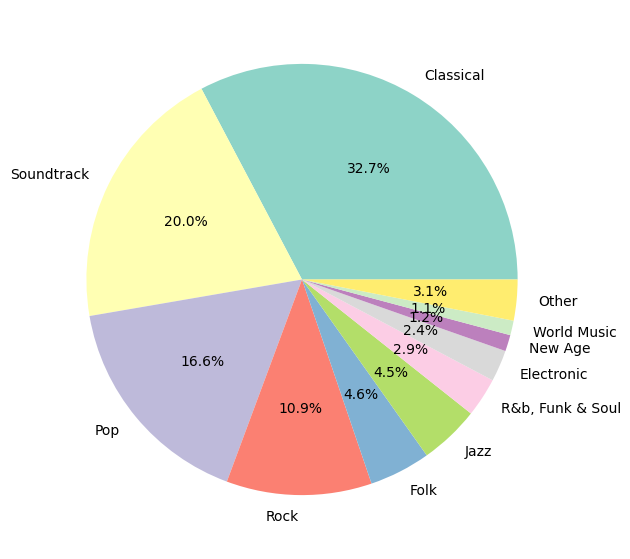

In [12]:
# Poiščemo najštevilčnejše
top_genres = genre_frequency.head(10)

# Preštejemo skupno število vseh ostalih
other_genres = genre_frequency["frequency"][10:].sum()

# Najštevilčnejšim žanrom dodamo podatek o ostalih
pie_data = pd.concat([top_genres, pd.DataFrame({'genre': ['Other'], 'frequency': [other_genres]})])

# Za namene grafa bomo kot indeks uporabili genre
pie_data = pie_data.set_index("genre")

# Podatki za grafični prikaz
pie_data.plot.pie(y="frequency", figsize=(7, 7), legend=False, autopct='%1.1f%%', ylabel="", colormap='Set3')

Iz grafa je razvidno, da je najpopularnejša glasbena zvrst klasična glasba, ki ji sledijo filmska, pop in rock glasba.

#### Glasbila

Podoben proces izvedemo tudi za glasbila.

In [13]:
# Za vsak inštrument preštejemo pripadajoče vnose ter jih ustrezno razvrstimo
instrument_frequency = instruments.groupby("instrument").size().sort_values(ascending=False)

# Popravimo indekse
instrument_frequency = instrument_frequency.reset_index(name='frequency')

instrument_frequency

,instrument,frequency
0,Piano,1721
1,Violin,91
...,...,...
30,Vocals,1
31,Woodwinds (other),1


Tudi tu je najprimernejši diagram za predstavitev podatkov krožni diagram.

<Axes: >

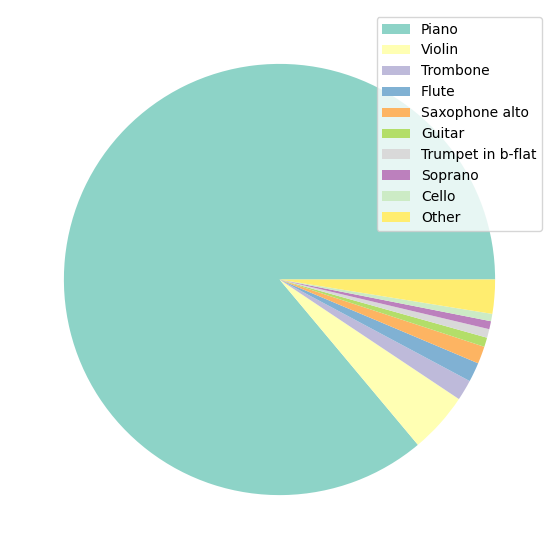

In [14]:
# Poiščemo najštevilčnejše
top_inst = instrument_frequency[instrument_frequency.frequency > 10]

# Preštejemo skupno število vseh ostalih
other_inst = instrument_frequency["frequency"][instrument_frequency.frequency <= 10].sum()

# Najštevilčnejšim žanrom dodamo podatek o ostalih
pie_data_inst = pd.concat([top_inst, pd.DataFrame({'instrument': ['Other'], 'frequency': [other_inst]})])

# Za namene grafa bomo kot indeks uporabili instrument
pie_data_inst = pie_data_inst.set_index("instrument")

# Podatki za grafični prikaz
pie_data_inst.plot.pie(y="frequency", figsize=(7, 7), ylabel="", labels=None, colormap='Set3')

Vidimo, da je daleč najbolj popularno glasbilo klavir, kateremu je namenjena več kot polovica vseh not.

#### Zasedbe

Naslednja kategorija, ki nas zanima, je kategorija zasedb.

In [15]:
ensemble_frequency = music.groupby("ensemble").size().sort_values(ascending=False)
ensemble_frequency = ensemble_frequency.reset_index(name='frequency')
ensemble_frequency

,ensemble,frequency
0,Solo Piano,1554
1,Solo Violin,56
...,...,...
55,Solo Harpsichord,1
56,Woodwind Quintet,1


Glavna opazka je, da so večinsko zastopana dela za solistično zasedbo.

#### Težavnostna stopnja

Podoben proces uporabimo tudi za težavnostne nivoje.

In [16]:
difficulty_frequency = music.groupby("difficulty").size().sort_values(ascending=False)
difficulty_frequency = difficulty_frequency.reset_index(name='frequency')
difficulty_frequency

,difficulty,frequency
0,Intermediate,743
1,Beginner,424
2,Advanced,228


Skladb za srednji nivo je največ, skladb za neprednejše glasbenike pa je najmanj.

#### Avtorji originalov

Nadaljujmo analizo z avtorji.

In [17]:
# Združimo tabeli music in authors glede na music_id
authors_merged = music.merge(relacije_authors, on="music_id")

# Za vsakega avtorja preštejemo pripadajoče vnose ter jih ustrezno razvrstimo
author_frequency = authors_merged.groupby("original_author").size().sort_values(ascending=False)

# Popravimo indekse
author_frequency = author_frequency.reset_index(name='frequency')

author_frequency

,original_author,frequency
0,137994,63
1,26416,55
...,...,...
607,142022,1
608,452182,1


In [18]:
author_frequency[author_frequency.frequency == 1].count()

original_author    344
frequency          344
dtype: int64

Opazimo, da se veliko avtorjev ponovi le enkrat. Tudi med tistimi, kjer je ponovitev več, so razlike zares majhne. Zaradi številčnosti avtorjev in majhnega razpona frekvenc pojavitev bo zato najbolj informativen škatlast graf.

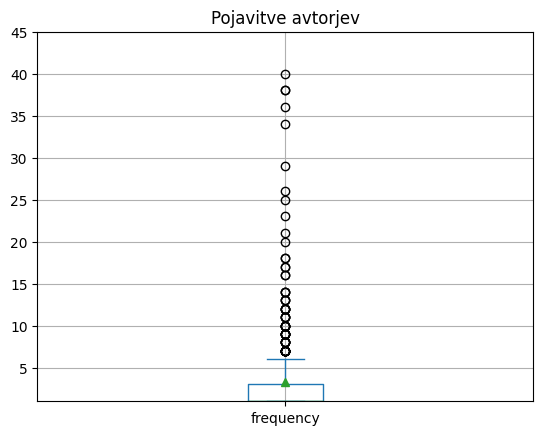

In [19]:
# Podatki za grafični prikaz
auth_plot = author_frequency.plot.box(column="frequency", grid=True, showmeans=True, ylim=(1, 45)).set_title('Pojavitve avtorjev')

Graf nam pokaže, da se pogostost pojavitev avtorjev največkrat giba v razponu od enega do treh vnosov. Višje, kot je število vnosov, manj avtorjev ga dosega. Poglejmo si le še, kateri so trije najpogostejši avtorji.

In [20]:
auth_top = author_frequency.head(3)
auth_top = pd.merge(auth_top, authors, left_on="original_author", right_on="author_id", how="inner")
auth_top

,original_author,frequency,name
0,137994,63,Frédéric Chopin
1,26416,55,Johann Sebastian Bach
2,26453,53,Ludwig Van Beethoven


Največkrat torej naletimo na skladbe, ki so jih v originalu napisali Frédéric Chopin, Johann Sebastian Bach in Ludwig Van Beethoven.

#### Uporabniki

Pri uporabnikih bo pristop nekoliko drugačen, saj se zdi obravnava, taka kot pri avtorjih, neinformativna. Zato si raje poglejmo, koliko različnih uporabnikov je objavilo skladbe za naslednje kategorije: inštrument, žanr, zasedbo in težavnost. Pri tem zaradi večjih razlik v zastopanosti znotraj kategorij upoštevamo razmerje, ki ga imenujemo razmerje raznolikosti [diversity_ratio]. Z drugimi besedami - zanima nas, kako raznolika je množica uporabnikov, ki so objavili dela znotraj izbranih kategorij. Cilj je predstaviti podatke v združenem škatlastem diagramu.

Preštejmo najprej uporabnike, ki so objavljali v posameznih žanrih.

In [21]:
# Tabelo, ki združuje žanre in skladbe, že imamo: zanri_povezano
# Potrebujemo še povezavo skladb z uporabniki
users_genres = pd.merge(zanri_povezano, relacije_users, on="music_id")

# Uporabimo .groupby, da ustrezno razdelimo podatke.
users_genres = users_genres.groupby("genre")["user_id"].nunique()

# Popravimo indekse in poimenujemo nov stolpec
users_genres = users_genres.reset_index(name="no_of_users")

# Potrebovali bomo podatke iz tabele genre_frequency
users_genres = users_genres.merge(genre_frequency, on="genre")

# Izračunamo odstotek
users_genres["diversity_ratio"] = (users_genres["no_of_users"] / users_genres["frequency"]).round(2)

users_genres

,genre,no_of_users,frequency,diversity_ratio
0,Blues,6,6,1.00
1,Classical,545,748,0.73
...,...,...,...,...
16,Soundtrack,393,457,0.86
17,World Music,21,25,0.84


Naprej nas enake informacije zanimajo za inštrumente.

In [22]:
# Združimo tabelo relacije_users s tabelo instruments preko music_id.
users_instruments = pd.merge(instruments, relacije_users, on="music_id")

# Na dobljeni tabeli ponovimo postopek
users_instruments = users_instruments.groupby("instrument")["user_id"].nunique()

users_instruments = users_instruments.reset_index(name="no_of_users")

users_instruments = users_instruments.merge(instrument_frequency, on="instrument")

users_instruments["diversity_ratio"] = (users_instruments["no_of_users"] / users_instruments["frequency"]).round(2)

users_instruments

,instrument,no_of_users,frequency,diversity_ratio
0,Accordion,4,5,0.8
1,Alto,1,1,1.0
...,...,...,...,...
30,Vocals,1,1,1.0
31,Woodwinds (other),1,1,1.0


Postopek je podoben tudi za zasedbe.

In [23]:
# Združimo tabelo relacije_users s tabelo music preko music_id.
users_povezano = pd.merge(music, relacije_users, on="music_id")

# Na dobljeni tabeli ponovimo postopek
users_ensemble = users_povezano.groupby("ensemble")["user_id"].nunique()

users_ensemble = users_ensemble.reset_index(name="no_of_users")

users_ensemble = users_ensemble.merge(ensemble_frequency, on="ensemble")

users_ensemble["diversity_ratio"] = (users_ensemble["no_of_users"] / users_ensemble["frequency"]).round(2)

users_ensemble

,ensemble,no_of_users,frequency,diversity_ratio
0,A Capella,2,4,0.5
1,Brass Ensemble,1,1,1.0
...,...,...,...,...
55,Woodwind Duet,5,5,1.0
56,Woodwind Quintet,1,1,1.0


Na koncu podatke poiščemo še za stopnjo težavnosti. Pri tem pazimo, da gledamo le vnose, kjer je podatek na voljo.

In [24]:
users_diff = users_povezano.groupby("difficulty")["user_id"].nunique()

users_diff = users_diff.reset_index(name="no_of_users")

users_diff = users_diff.merge(difficulty_frequency, on="difficulty")

users_diff["diversity_ratio"] = (users_diff["no_of_users"] / users_diff["frequency"]).round(2)

users_diff

,difficulty,no_of_users,frequency,diversity_ratio
0,Advanced,173,228,0.76
1,Beginner,334,424,0.79
2,Intermediate,569,743,0.77


Podatke združimo v graf.

<Axes: >

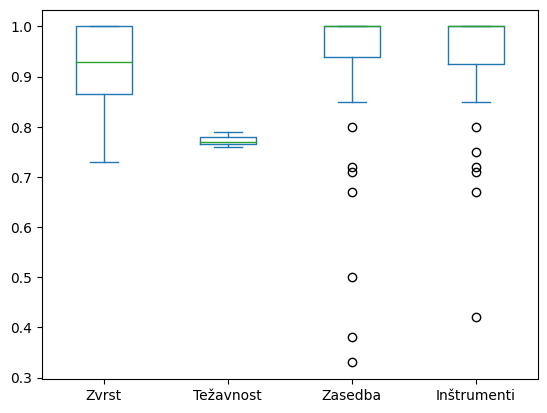

In [25]:
# Združitev zgornjih tabel
combined_diversity = pd.concat([users_genres, users_diff, users_ensemble, users_instruments], keys=['Zvrst', 'Težavnost', 'Zasedba', 'Inštrumenti'])

# Priprava podatkov za grafično ponazoritev
view = combined_diversity['diversity_ratio'].unstack(level=0)
view.plot(kind='box')

<Axes: ylabel='Density'>

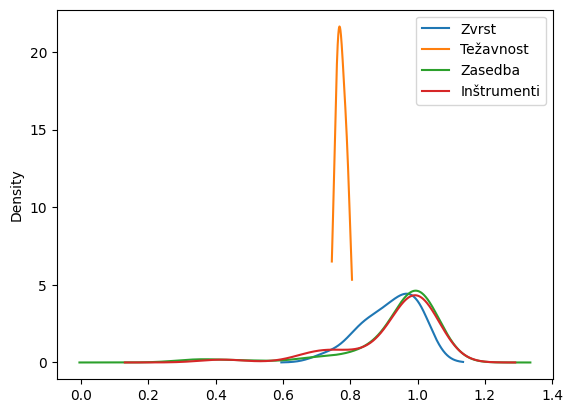

In [26]:
view.plot(kind='density')

Zgornji graf ponazarja, kakšna razmerja raznolikosti prevladujejo v posameznih kategorijah. Nazorno pokaže, da sta kategoriji inštrumentov in zasedb najbolj raznoliki - večinoma imajo njuni elementi razmerje raznolikosti 1. Pri tem pa poudarjam, da je pri teh dveh kategorijah tudi veliko elementov, ki imajo le po eno skladbo, zato naše razmerje ne riše realne slike. Smiselno je podatke dodatno filtrirati, da izpustimo elemente, pri katerih so podatki lahko zavajujoči.  

V ta namen dodajam še graf, ki obravnava le elemente, ki imajo smiselno količino podatkov.

<Axes: >

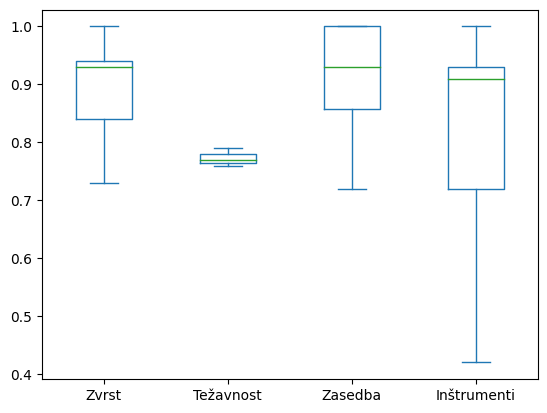

In [27]:
# Uveljavitev filtrov
# Med žanri izberemo tiste, ki jim pripada vsaj 1% skladb
users_genres_top = users_genres[users_genres.frequency >= 10]
# Med glasbili izberemo tista, ki jim pripada vsaj 1% skladb
users_instruments_top = users_instruments[users_instruments.frequency >= 10]
# Težavnosti imajo smiselno razporeditev brez filtriranja
users_diff_top = users_diff[users_diff.frequency >= 10]
# Med zasedbami izberemo tiste, ki jim pripada vsaj 0,9% skladb
users_ensemble_top = users_ensemble[users_ensemble.frequency >= 9]

# Združitev tabel
combined_diversity = pd.concat([users_genres_top, users_diff_top, users_ensemble_top, users_instruments_top], keys=['Zvrst', 'Težavnost', 'Zasedba', 'Inštrumenti'])


# Priprava podatkov za grafično ponazoritev
view_top = combined_diversity['diversity_ratio'].unstack(level=0)
view_top.plot(kind='box')


<Axes: ylabel='Density'>

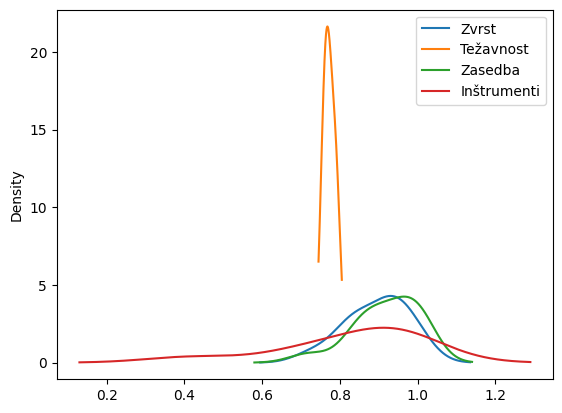

In [28]:
view_top.plot(kind='density')

S tem smo prišli do grafov, na podlagi katerih si upamo sklepati več, saj vključujejo bolj smiselne dele podatkov.  
* Opazimo lahko, da je težavnost zelo homogena kategorija - pri vseh imamo uporabnike, ki so objavili več kot eno skladbo v dani težavnosti. Ker je majhna, in ker se posamezni elementi ne drastično razlikujejo v količini pripadajočih skladb, nam ta del grafa da zanesljivo sliko o razmerju raznolikosti. Hkrati pa v nasprotju s prvim grafom opazimo, da imamo pri njej najizrazitejši vrh. Ker podatkov nismo spreminjali, je lahko to kontrolna točka, s katero primerjamo spremembe ostalih treh kategorij
* Kategorija žanrov (glasbenih zvrsti) je tudi precej uravnotežena, saj razen klasične glasbe noben žanr ne zares izstopa, odstranili smo le nekaj manj pogostih žanrov. Zato je podobna oblika na obeh grafih pričakovana. Kar iz niju razberemo pa je, da imamo v tej kategoriji več različnih razmerij raznolikosti, pri čemer rahlo izstopa območje med 0.9 in 1.0. V kategoriji imamo torej žanre, v katerih je raznolikost uporabnikov zelo visoka.
* Kategoriji zasedb in inštrumentov (glasbil) sta si bili na prvih grafih zelo podobni, na drugih dveh pa se njuna oblika precej razlikuje. Iz tega se da sklepati, da imata obe veliko predstavnikov, ki pripadajo zelo malo skladbam in so zato prispevali k višku na vrednosti 1.0. To potrjujejo tudi grafi pojavitev za obe kategoriji
* Kategorija inštrumentov ima največji del predstavnikov, kjer je skoraj vsaka skladba delo drugega uporabnika
* Kategorija zasedb ima najbolj uravnoteženo porazdelitev med različnimi razmerji raznolikosti.

#### Zaključek

Pri količinski analizi smo poiskali osnovne podatke o porazdelitvi skladb v različnih kategorijah in pri vsaki poiskali najbolj dominantno. Pri uporabnikih 

### Popularnost

#### Opredelitev merila popularnosti

Naslednji problem, ki se ga lotimo, je obravnava popularnosti skladb. Najprej si poglejmo ocene.

In [29]:
min(music.rating)

4.51

Vidimo, da ocen manjših od 4.51 ni, torej te ne bodo zares informativne. Zato nas bo za oceno popularnosti skladbe bolj zanimalo razmerje med ljudmi, ki so jo videli, in ljudmi, ki so jo dodali med najljubše. Poimenujmo ga indeks popularnosti ["popularity_index"] in ga dodajmo v našo tabelo. Hkrati lahko odstranimo stolpca "votes" in "stars", saj nam ne zares koristita.

Razmerje bomo izračunali preko formule $$ \text{popularity index} = \frac{\text{favorites}}{\text{views}}$$

In [30]:
music["popularity_index"] = ((music["favorites"] / music["views"])).round(4)

In [31]:
music.sort_values(by="popularity_index", ascending=False)

,title,rating,votes,ensemble,all_instruments,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link,duration_seconds,popularity_index
music_id,,,,,,,,,,,,,,,,,
8775498,Golden hour,4.84,1168,Solo Piano,[Piano],"E major, C♯ minor","Oct 08, 2022",01:30,NE,6731,Intermediate,4,53069,1,https://musescore.com/user/84433/scores/8775498,90.0,0.1268
5273840,"Coldplay ""Clocks""",4.73,964,Solo Piano,[Piano],"A♭ major, F minor","Oct 17, 2018",04:00,NE,4669,Beginner,3,37082,1,https://musescore.com/user/28698337/scores/527...,240.0,0.1259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077553,Va pensiero,4.81,354,SATB,[Piano],"F♯ major, D♯ minor","May 01, 2018",04:13,DA,173,NaN,9,24527,5,https://musescore.com/user/1964776/scores/5077553,253.0,0.0071
6259956,Para Elisa - Original - Beethoven,4.79,554,Solo Piano,[Piano],"C major, A minor","Jul 21, 2020",03:32,DA,592,Intermediate,3,121894,1,https://musescore.com/user/35600168/scores/625...,212.0,0.0049


In [32]:
music_new = music.drop(columns=["votes", "rating"])
music_new = music_new.sort_values(by="popularity_index", ascending=False)
music_new

,title,ensemble,all_instruments,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link,duration_seconds,popularity_index
music_id,,,,,,,,,,,,,,,
8775498,Golden hour,Solo Piano,[Piano],"E major, C♯ minor","Oct 08, 2022",01:30,NE,6731,Intermediate,4,53069,1,https://musescore.com/user/84433/scores/8775498,90.0,0.1268
5273840,"Coldplay ""Clocks""",Solo Piano,[Piano],"A♭ major, F minor","Oct 17, 2018",04:00,NE,4669,Beginner,3,37082,1,https://musescore.com/user/28698337/scores/527...,240.0,0.1259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077553,Va pensiero,SATB,[Piano],"F♯ major, D♯ minor","May 01, 2018",04:13,DA,173,NaN,9,24527,5,https://musescore.com/user/1964776/scores/5077553,253.0,0.0071
6259956,Para Elisa - Original - Beethoven,Solo Piano,[Piano],"C major, A minor","Jul 21, 2020",03:32,DA,592,Intermediate,3,121894,1,https://musescore.com/user/35600168/scores/625...,212.0,0.0049


#### Popularnost po kategorijah

Ko smo ugotovili splošno urejenost po popularnosti nas zanima popularnost originalov. S pomočjo tabele relacije_author uredimo originalne naslove po njihovi popularnosti glede na zgornjo tabelo. 
Natančneje, tudi za originale izračunamo popularnostni indeks. Tega izračunamo kot povprečni popularnostni indeks za pripadajoče skladbe.

In [33]:
authors_merged = relacije_authors.merge(music_new, on= "music_id")

originals_popularity = authors_merged.groupby(["original_author", "original_title"])["popularity_index"].mean().reset_index()

originals_popularity.sort_values(by="popularity_index", ascending=False)

,original_author,original_title,popularity_index
1065,227288,Fairly Oddparents Theme Song,0.1021
499,135375,Victor's Piano Solo,0.0879
...,...,...,...
199,31365,Nabucco,0.0071
885,170457,Para Elisa,0.0049


Pripravimo si podatke za drugi del naloge. Potrebujemo izračun popularnosti za vsako kategorijo posebej. Pri tem bo popularnost pravzaprav simetrična pojmu verjetnosti - kako verjetno je, da bo skladba z določenim parametrom popularna.

In [34]:
# Popularnost žanrov
genre_merged = genres.merge(music_new, on= "music_id")

genres_popularity = genre_merged.groupby(["genre"])["popularity_index"].mean().reset_index()

genres_popularity.sort_values(by="popularity_index", ascending=False)

,genre,popularity_index
3,Country,0.048445
0,Blues,0.043050
...,...,...
6,Experimental,0.022567
2,Comedy,0.019375


In [35]:
# Popularnost glasbil
instruments_merged = instruments.merge(music_new, on= "music_id")

instrumentss_popularity = instruments_merged.groupby(["instrument"])["popularity_index"].mean().reset_index()

instrumentss_popularity.sort_values(by="popularity_index", ascending=False)

,instrument,popularity_index
25,Trombone tenor,0.046300
10,Flute,0.039048
...,...,...
9,Flugelhorn,0.012300
19,Snare drum,0.010800


In [36]:
# Popularnost težavnosti

diff_popularity = music_new.groupby(["difficulty"])["popularity_index"].mean().reset_index()

diff_popularity.sort_values(by="popularity_index", ascending=False)

,difficulty,popularity_index
2,Intermediate,0.035958
1,Beginner,0.035585
0,Advanced,0.034798


In [37]:
# Popularnost zasedb

ensembles_popularity = music_new.groupby(["ensemble"])["popularity_index"].mean().reset_index()

ensembles_popularity.sort_values(by="popularity_index", ascending=False)

,ensemble,popularity_index
19,Piano Four Hand,0.053883
43,Solo Trombone tenor,0.046300
...,...,...
17,Percussion Quartet,0.010800
23,SATB,0.010550


In [38]:
# Popularnost tonalitet

keys_popularity = music_new.groupby(["key"])["popularity_index"].mean().reset_index()

keys_popularity.sort_values(by="popularity_index", ascending=False)

,key,popularity_index
2,"A♭ major, F minor",0.036817
8,"E major, C♯ minor",0.036571
...,...,...
7,"D♭ major, B♭ minor",0.031977
11,"F♯ major, D♯ minor",0.029560


#### Je več res bolje?

V prejšnjih dveh poglavjih sem se s popularnostjo in količinsko sliko podatkov ukvarjala ločeno. Zaradi narave podatkov pa se pojavi vprašanje, kako sta ta dva parametra povezana. So tisti, ki jih je več, tudi bolj priljubljeni? Kako bi lahko tako povezavo izrazili s številko? Kako robni primeri vplivajo nanjo?

Najprej preverim najosnovnejšo povezavo - kako popularne so najbolj zastopane originalne skladbe?

In [39]:
ultimate_popularity_orig = pd.merge(originals, originals_popularity, on=["original_author", "original_title"])
ultimate_popularity_orig = ultimate_popularity_orig.groupby("repetitions").popularity_index_orig.mean().plot(x="repetitions", y="popularity_index_orig", kind="barh")

AttributeError: 'DataFrameGroupBy' object has no attribute 'popularity_index_orig'

Iz grafa je razvidno, da število skladb, ki pripada originalu, ne tudi nujno pomeni, da bo original popularen.

In [41]:
compare_diff = diff_popularity.merge(difficulty_frequency, on="difficulty")
compare_diff.transpose

,difficulty,popularity_index,frequency
0,Advanced,0.034798,228
1,Beginner,0.035585,424
2,Intermediate,0.035958,743


### Klasična glasba

Klasična glasba velja za osnovo in hkrati sam vrh glasbenega ustvarjanja. V glasbenih šolah je največji poudarek na učenju klasičnih del, s katerimi glasbeniki pridobijo osnovno znanje in tehniko, ki jim pomaga pri izvajanju ostalih del. Skozi klasična dela razumemo, kako se glasba spreminja skozi leta, je katalog razvoja tehnik, inštrumentov in glasbenih okusov. V tej kategoriji najdemo najosnovnejše vaje in tudi najveličastnejša dela, ki nosijo velik zgodovinski pomen. Kategoriji, ki vključuje tako širok spekter del, bom zato posvetila posebno pozornost.

Za začetek me zanima, kako se klasična dela primerjajo z ostalimi. Pri tem bom pozorna na dejstvo, da se pri posameznih skladbah lahko pojavi več žanrov hkrati, zato bom skladbe najprej razdelila na tiste, ki spadajo med klasike in tiste, ki ne.

In [ ]:
# tabela klasičnih skladb
classics = zanri_povezano[zanri_povezano.genre == "Classical"]

# indeksi klasik
classics_id = classics[["music_id"]]

# tabela skladb, ki ne spadajo med klasike
not_classics = pd.merge(music, classics_id, on="music_id", how="left", indicator=True)
not_classics = not_classics[not_classics._merge == "left_only"]

classics

,music_id,title,rating,votes,ensemble,all_instruments,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link,duration_seconds,genre
0,4197961,Merry-Go-Round of Life: Howl's Moving Castle P...,4.77,47676,Solo Piano,[Piano],"B♭ major, G minor","Jul 05, 2017",05:15,NE,181934,Intermediate,7,4589622,1,https://musescore.com/user/16006641/scores/419...,315.0,Classical
2,3291706,River Flows In You,4.68,45503,Solo Piano,[Piano],"A major, F♯ minor","Jan 24, 2017",02:47,NE,207886,Intermediate,4,5975850,1,https://musescore.com/user/12461571/scores/329...,167.0,Classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,648766,Puccini: O mio babbino caro,4.77,326,Piano-Voice,[Piano],"A♭ major, F minor","Feb 16, 2015",01:36,NE,686,NaN,4,33888,2,https://musescore.com/user/286836/scores/648766,96.0,Classical
2281,5119837,Canon in D - Violin Cello,4.77,325,String Duet,[Violin],"D major, B minor","Jun 02, 2018",03:49,DA,1043,NaN,4,32778,2,https://musescore.com/user/28717866/scores/511...,229.0,Classical


Sedaj lahko tabeli primerjamo. Odgovoriti želimo na naslednja vprašanja:
* So klasike daljše od ostalih? So težje? Trajajo dlje? So kompleksnejše - imajo več delov? 
* Kakšna je raznolikost tonalitet pri klasikah, in v primerjavi z neklasičnimi deli?
* Imajo klasike večjo raznolikost v inštrumentih?

In [ ]:
# Najpogostejša težavnost
classics_diff = classics.groupby("difficulty").size()
classics_diff = classics_diff.reset_index(name='count')
classics_diff.set_index('difficulty', inplace=True)


not_classics_diff = not_classics.groupby("difficulty").size()
not_classics_diff = not_classics_diff.reset_index(name='count')
not_classics_diff.set_index('difficulty', inplace=True)

# Primerjava težavnosti
how_hard = pd.DataFrame({
    "type" : ["Klasike", "Ostale"],
    "Beginner" : [classics_diff.at["Beginner", "count"], not_classics_diff.at["Beginner", "count"]], 
    "Intermediate" : [classics_diff.at["Intermediate", "count"], not_classics_diff.at["Intermediate", "count"]],
    "Advanced" : [classics_diff.at["Advanced", "count"], not_classics_diff.at["Advanced", "count"]]
})

how_hard.set_index("type", inplace=True)
how_hard

,Beginner,Intermediate,Advanced
type,,,
Klasike,128,245,123
Ostale,296,498,105


<Axes: >

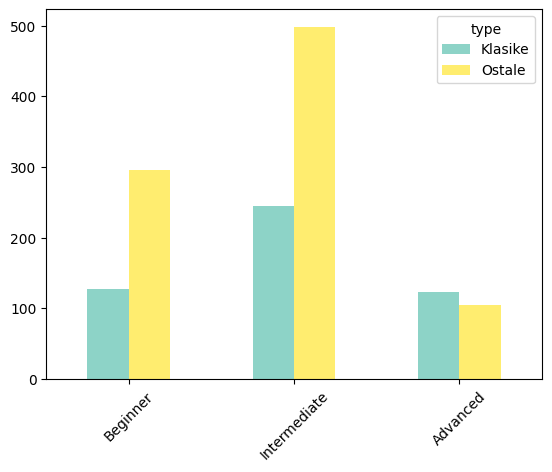

In [ ]:
transposed = how_hard.transpose()
transposed.plot.bar(rot = 45, colormap = "Set3")

In [ ]:
# Primerjava ostalih parametrov
comparsion =  pd.DataFrame({
    "type" : ["Klasike", "Ostale"],
    "pages" : [classics.pages.mean().round(2), not_classics.pages.mean().round(2)], 
    "parts" : [classics.parts.mean().round(2), not_classics.parts.mean().round(2)],
    "duration_seconds" : [classics.duration_seconds.mean().round(2), not_classics.duration_seconds.mean().round(2)],
})

comparsion

,type,pages,parts,duration_seconds
0,Klasike,7.01,1.88,256.89
1,Ostale,5.57,1.77,190.94


Zanima me, koliko različnih inštrumentov in tonalitet je zastopanih v klasikah, in kako se to primerja z ostalimi.

In [ ]:
classics_instruments = classics.merge(instruments, right_on="music_id", left_on="music_id")
classics_instruments

,music_id,title,rating,votes,ensemble,all_instruments,key,date,duration,public_domain,favorites,difficulty,pages,views,parts,link,duration_seconds,genre,instrument
0,4197961,Merry-Go-Round of Life: Howl's Moving Castle P...,4.77,47676,Solo Piano,[Piano],"B♭ major, G minor","Jul 05, 2017",05:15,NE,181934,Intermediate,7,4589622,1,https://musescore.com/user/16006641/scores/419...,315.0,Classical,Piano
1,3291706,River Flows In You,4.68,45503,Solo Piano,[Piano],"A major, F♯ minor","Jan 24, 2017",02:47,NE,207886,Intermediate,4,5975850,1,https://musescore.com/user/12461571/scores/329...,167.0,Classical,Piano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,648766,Puccini: O mio babbino caro,4.77,326,Piano-Voice,[Piano],"A♭ major, F minor","Feb 16, 2015",01:36,NE,686,NaN,4,33888,2,https://musescore.com/user/286836/scores/648766,96.0,Classical,Piano
747,5119837,Canon in D - Violin Cello,4.77,325,String Duet,[Violin],"D major, B minor","Jun 02, 2018",03:49,DA,1043,NaN,4,32778,2,https://musescore.com/user/28717866/scores/511...,229.0,Classical,Violin


In [ ]:
# Združimo s tabelo o inštrumentih
classics_instruments = classics.merge(instruments, right_on="music_id", left_on="music_id")
nc_instruments = not_classics.merge(instruments, right_on="music_id", left_on="music_id")

c_grouped = classics_instruments.groupby("instrument")
nc_grouped = nc_instruments.groupby("instrument")

# Nova tabela
klasike = pd.DataFrame({
    "instrument" : list(c_grouped.groups.keys())
})

klasike["count_classics"] = c_grouped.size()[klasike.instrument]

ostale = pd.DataFrame({
    "instrument" : list(nc_grouped.groups.keys())
})

#ostale["count_other"] = c_grouped.size()[ostale.instrument]
klasike


,instrument,count_classics
0,Accordion,NaN
1,Bass guitar,NaN
...,...,...
20,Violin,NaN
21,Woodwinds (other),NaN


## _Drugi del_: Napovedovanje popularnosti

Napovedovalec popularnosti bo popularnost računal glede na parametre : žanr, glasbila, originalni avtor, zasedba, tonaliteta, težavnost.
Princip delovanja bo sledil teoriji Naivnega Bayesovega klasifikatorja, o kateri smo govorili na predavanjih.
Uporabili bomo podatke o popularnosti za posamezne parametre iz prvega dela naloge, potem pa jih upoštevali pri izračunu popularnosti skladb.